# Simplified P2P Federated Learning Analysis

This notebook analyzes the 5 essential metrics for decentralized P2P experiments:
1. **Accuracy** of each client overall for each round
2. **Accuracy per class** of each client for each round
3. **Loss** per round of each client
4. **Gradient norm** of each client per round
5. **Gradient changes** per round of each client

In [153]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import numpy as np
import os

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (12, 6)

print("Setup complete!")

Setup complete!


## Load Experiment Data

In [154]:
def load_latest_experiments(logs_dir="logs"):
    """
    Load CSVs from the latest experiment of each comparison method,
    ignoring centralized_fedavg.
    """
    dfs = {}

    IGNORE_DIRS = {"centralized_fedavg"}

    for method_dir in os.listdir(logs_dir):
        if method_dir in IGNORE_DIRS:
            continue

        method_path = os.path.join(logs_dir, method_dir)

        if not os.path.isdir(method_path):
            continue

        # Get all experiment folders
        experiments = [
            d for d in os.listdir(method_path)
            if os.path.isdir(os.path.join(method_path, d))
        ]

        if not experiments:
            continue

        # Latest experiment (timestamp format sorts correctly)
        latest_exp = max(experiments)
        latest_path = os.path.join(method_path, latest_exp)

        # Method name cleanup
        method_name = method_dir.replace("_comparison", "")

        # Expected CSVs
        csv_files = {
            "p2p_metrics.csv": f"{method_name}_p2p_metrics_df",
            "p2p_per_class_metrics.csv": f"{method_name}_p2p_per_class_df"
        }

        for csv_file, df_name in csv_files.items():
            csv_path = os.path.join(latest_path, csv_file)

            if os.path.exists(csv_path):
                dfs[df_name] = pd.read_csv(csv_path)

    return dfs

dfs = load_latest_experiments("logs")

jaccard_p2p_metrics_df = dfs["jaccard_p2p_metrics_df"]
jaccard_p2p_per_class_df = dfs["jaccard_p2p_per_class_df"]

matcha_p2p_metrics_df = dfs["matcha_p2p_metrics_df"]
matcha_p2p_per_class_df = dfs["matcha_p2p_per_class_df"]

max_degree_p2p_metrics_df = dfs["max_degree_p2p_metrics_df"]
max_degree_p2p_per_class_df = dfs["max_degree_p2p_per_class_df"]

metropolis_p2p_metrics_df = dfs["metropolis_hastings_p2p_metrics_df"]
metropolis_p2p_per_class_df = dfs["metropolis_hastings_p2p_per_class_df"]

metropolis_p2p_metrics_df.columns, metropolis_p2p_per_class_df.columns



(Index(['client_id', 'round', 'cluster_id', 'train_accuracy', 'train_loss',
        'test_accuracy', 'test_loss', 'gradient_norm', 'gradient_change'],
       dtype='str'),
 Index(['client_id', 'round', 'cluster_id', 'class_id', 'class_accuracy',
        'class_precision', 'class_recall', 'class_f1_score'],
       dtype='str'))

## AVG Test Accuracy per round

In [155]:
import plotly.graph_objects as go

fig = go.Figure()

methods = [
    ("jaccard", jaccard_p2p_metrics_df, "green"),
    ("matcha", matcha_p2p_metrics_df, "blue"),
    ("max_degree", max_degree_p2p_metrics_df, "orange"),
    ("metropolis_hastings", metropolis_p2p_metrics_df, "yellow")
]

for method_name, df, color in methods:
    print(f"\n{method_name.upper()}:")
    print(f"Shape: {df.shape}")
    print(f"Columns: {df.columns.tolist()}")
    
    if "round" in df.columns and "test_accuracy" in df.columns:
        avg_acc = (
            df.groupby("round")["test_accuracy"]
            .mean()
            .sort_index()
        )
        
        print(f"Data points: {len(avg_acc)}")
        print(f"Round range: {avg_acc.index.min()} to {avg_acc.index.max()}")
        print(f"Accuracy range: {avg_acc.min():.4f} to {avg_acc.max():.4f}")
        
        fig.add_trace(go.Scatter(
            x=avg_acc.index,
            y=avg_acc.values,
            mode='lines+markers',
            name=method_name.replace('_', ' ').title(),
            line=dict(color=color, width=2),
            marker=dict(size=6)
        ))
    else:
        print(f"WARNING: Missing required columns!")

fig.update_layout(
    title="Average Test Accuracy per Round (All Methods)",
    xaxis_title="Round",
    yaxis_title="Average Test Accuracy",
    hovermode='x unified',
    template='plotly_white',
    font=dict(size=12),
    legend=dict(
        yanchor="bottom",
        y=0.01,
        xanchor="right",
        x=0.99
    ),
    width=1000,
    height=600
)

fig.show()


JACCARD:
Shape: (8000, 9)
Columns: ['client_id', 'round', 'cluster_id', 'train_accuracy', 'train_loss', 'test_accuracy', 'test_loss', 'gradient_norm', 'gradient_change']
Data points: 200
Round range: 1 to 200
Accuracy range: 9.9992 to 50.1400

MATCHA:
Shape: (8000, 9)
Columns: ['client_id', 'round', 'cluster_id', 'train_accuracy', 'train_loss', 'test_accuracy', 'test_loss', 'gradient_norm', 'gradient_change']
Data points: 200
Round range: 1 to 200
Accuracy range: 12.4767 to 36.9395

MAX_DEGREE:
Shape: (8000, 9)
Columns: ['client_id', 'round', 'cluster_id', 'train_accuracy', 'train_loss', 'test_accuracy', 'test_loss', 'gradient_norm', 'gradient_change']
Data points: 200
Round range: 1 to 200
Accuracy range: 10.0000 to 51.0403

METROPOLIS_HASTINGS:
Shape: (8000, 9)
Columns: ['client_id', 'round', 'cluster_id', 'train_accuracy', 'train_loss', 'test_accuracy', 'test_loss', 'gradient_norm', 'gradient_change']
Data points: 200
Round range: 1 to 200
Accuracy range: 10.0000 to 50.6570


## AVG Train accuracy per round

In [156]:
import plotly.graph_objects as go

fig = go.Figure()

methods = [
    ("jaccard", jaccard_p2p_metrics_df, "green"),
    ("matcha", matcha_p2p_metrics_df, "blue"),
    ("max_degree", max_degree_p2p_metrics_df, "orange"),
    ("metropolis_hastings", metropolis_p2p_metrics_df, "yellow")
]

for method_name, df, color in methods:
    print(f"\n{method_name.upper()}:")
    print(f"Shape: {df.shape}")
    print(f"Columns: {df.columns.tolist()}")
    
    if "round" in df.columns and "train_accuracy" in df.columns:
        avg_acc = (
            df.groupby("round")["train_accuracy"]
            .mean()
            .sort_index()
        )
        
        print(f"Data points: {len(avg_acc)}")
        print(f"Round range: {avg_acc.index.min()} to {avg_acc.index.max()}")
        print(f"Accuracy range: {avg_acc.min():.4f} to {avg_acc.max():.4f}")
        
        fig.add_trace(go.Scatter(
            x=avg_acc.index,
            y=avg_acc.values,
            mode='lines+markers',
            name=method_name.replace('_', ' ').title(),
            line=dict(color=color, width=2),
            marker=dict(size=6)
        ))
    else:
        print(f"WARNING: Missing required columns!")

fig.update_layout(
    title="Average Train Accuracy per Round (All Methods)",
    xaxis_title="Round",
    yaxis_title="Average Train Accuracy",
    hovermode='x unified',
    template='plotly_white',
    font=dict(size=12),
    legend=dict(
        yanchor="bottom",
        y=0.01,
        xanchor="right",
        x=0.99
    ),
    width=1000,
    height=600
)

fig.show()


JACCARD:
Shape: (8000, 9)
Columns: ['client_id', 'round', 'cluster_id', 'train_accuracy', 'train_loss', 'test_accuracy', 'test_loss', 'gradient_norm', 'gradient_change']
Data points: 200
Round range: 1 to 200
Accuracy range: 10.7260 to 94.4560

MATCHA:
Shape: (8000, 9)
Columns: ['client_id', 'round', 'cluster_id', 'train_accuracy', 'train_loss', 'test_accuracy', 'test_loss', 'gradient_norm', 'gradient_change']
Data points: 200
Round range: 1 to 200
Accuracy range: 12.1360 to 99.6400

MAX_DEGREE:
Shape: (8000, 9)
Columns: ['client_id', 'round', 'cluster_id', 'train_accuracy', 'train_loss', 'test_accuracy', 'test_loss', 'gradient_norm', 'gradient_change']
Data points: 200
Round range: 1 to 200
Accuracy range: 10.7080 to 95.4640

METROPOLIS_HASTINGS:
Shape: (8000, 9)
Columns: ['client_id', 'round', 'cluster_id', 'train_accuracy', 'train_loss', 'test_accuracy', 'test_loss', 'gradient_norm', 'gradient_change']
Data points: 200
Round range: 1 to 200
Accuracy range: 10.6720 to 91.2220


## AVG Train loss per round

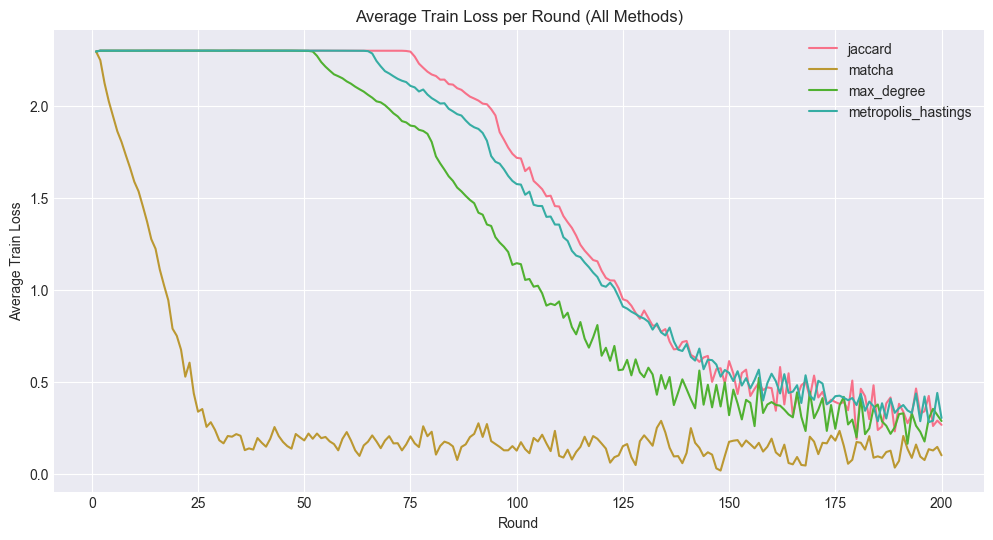

In [157]:
import matplotlib.pyplot as plt

plt.figure()

for name, df in dfs.items():
    if not name.endswith("_p2p_metrics_df"):
        continue

    method_name = name.replace("_p2p_metrics_df", "")

    avg_train_loss = (
        df.groupby("round")["train_loss"]
        .mean()
        .sort_index()
    )

    plt.plot(avg_train_loss.index, avg_train_loss.values, label=method_name)

plt.xlabel("Round")
plt.ylabel("Average Train Loss")
plt.title("Average Train Loss per Round (All Methods)")
plt.legend()
plt.grid(True)

plt.show()


## AVG test loss 

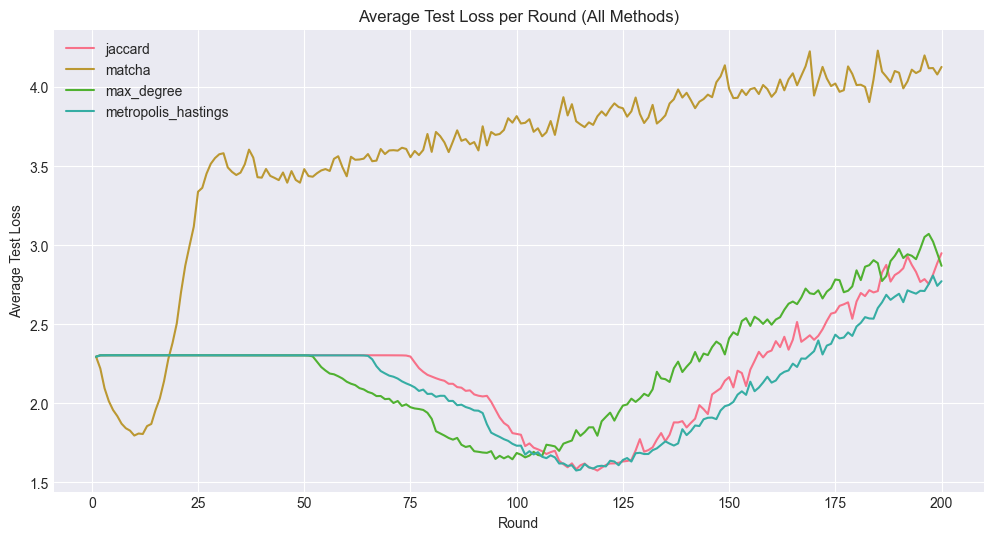

In [158]:
plt.figure()

for name, df in dfs.items():
    if not name.endswith("_p2p_metrics_df"):
        continue

    method_name = name.replace("_p2p_metrics_df", "")

    avg_test_loss = (
        df.groupby("round")["test_loss"]
        .mean()
        .sort_index()
    )

    plt.plot(avg_test_loss.index, avg_test_loss.values, label=method_name)

plt.xlabel("Round")
plt.ylabel("Average Test Loss")
plt.title("Average Test Loss per Round (All Methods)")
plt.legend()
plt.grid(True)

plt.show()


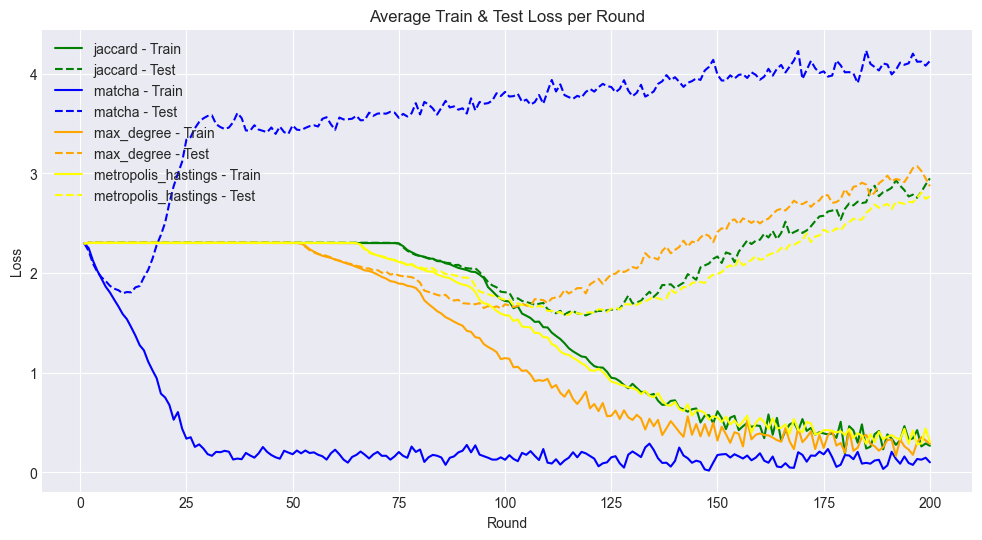

In [159]:
import matplotlib.pyplot as plt

methods = [
    ("jaccard", jaccard_p2p_metrics_df, "green"),
    ("matcha", matcha_p2p_metrics_df, "blue"),
    ("max_degree", max_degree_p2p_metrics_df, "orange"),
    ("metropolis_hastings", metropolis_p2p_metrics_df, "yellow"),
]

plt.figure()

for name, df, color in methods:
    grouped = df.groupby("round").mean().sort_index()

    # Train loss (solid)
    plt.plot(
        grouped.index,
        grouped["train_loss"],
        color=color,
        label=f"{name} - Train"
    )

    # Test loss (dashed)
    plt.plot(
        grouped.index,
        grouped["test_loss"],
        linestyle="--",
        color=color,
        label=f"{name} - Test"
    )

plt.xlabel("Round")
plt.ylabel("Loss")
plt.title("Average Train & Test Loss per Round")
plt.legend()
plt.grid(True)

plt.show()


## AVG accuracies per round by cluster of methods 

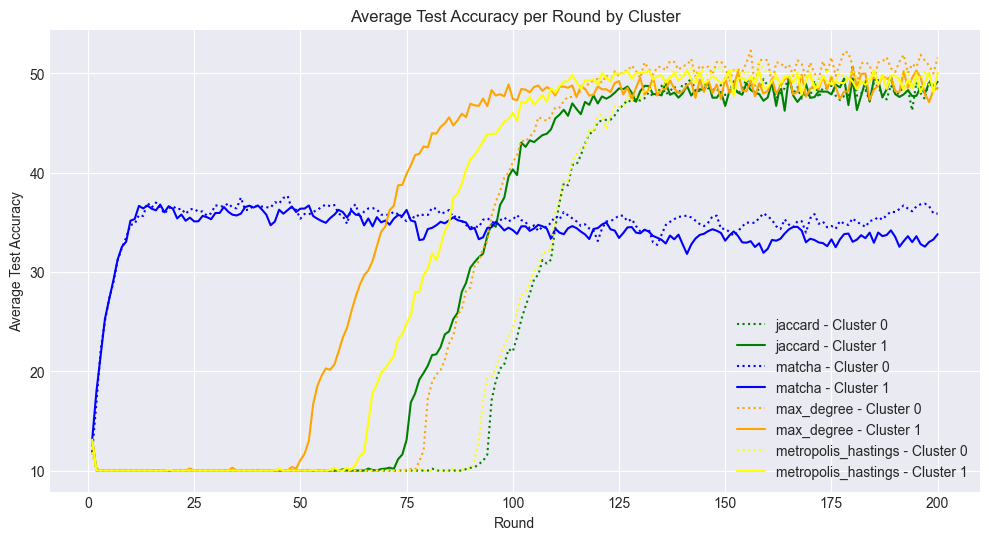

In [160]:
import matplotlib.pyplot as plt

methods = [
    ("jaccard", jaccard_p2p_metrics_df, "green"),
    ("matcha", matcha_p2p_metrics_df, "blue"),
    ("max_degree", max_degree_p2p_metrics_df, "orange"),
    ("metropolis_hastings", metropolis_p2p_metrics_df, "yellow"),
]

plt.figure()

for name, df, color in methods:
    
    # Ensure sorting
    df = df.sort_values("round")

    # Cluster 0
    cluster_0 = (
        df[df["cluster_id"] == 0]
        .groupby("round")["test_accuracy"]
        .mean()
    )

    # Cluster 1
    cluster_1 = (
        df[df["cluster_id"] == 1]
        .groupby("round")["test_accuracy"]
        .mean()
    )

    # Plot Cluster 0 (dotted)
    plt.plot(
        cluster_0.index,
        cluster_0.values,
        linestyle=":",
        color=color,
        label=f"{name} - Cluster 0"
    )

    # Plot Cluster 1 (solid)
    plt.plot(
        cluster_1.index,
        cluster_1.values,
        linestyle="-",
        color=color,
        label=f"{name} - Cluster 1"
    )

plt.xlabel("Round")
plt.ylabel("Average Test Accuracy")
plt.title("Average Test Accuracy per Round by Cluster")
plt.legend()
plt.grid(True)

plt.show()


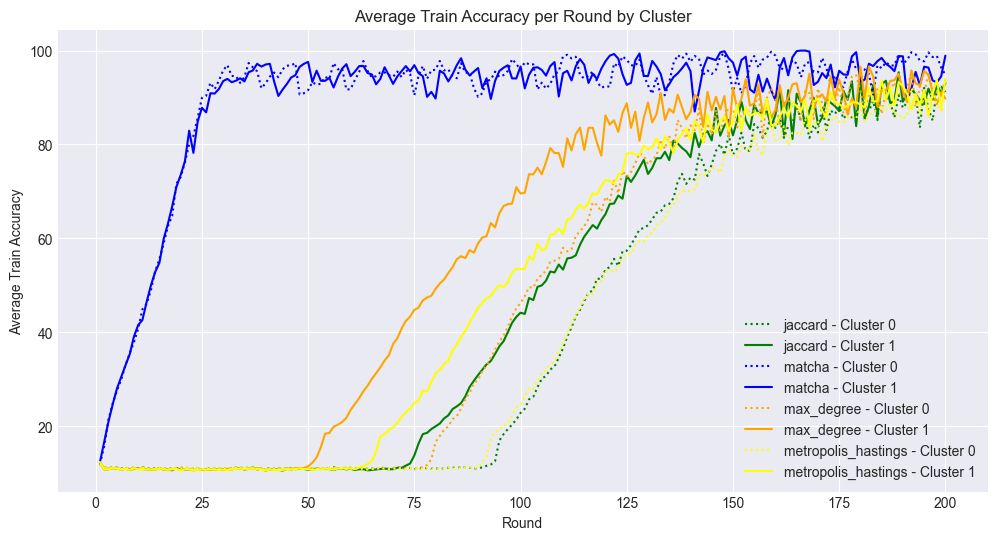

In [161]:
import matplotlib.pyplot as plt

methods = [
    ("jaccard", jaccard_p2p_metrics_df, "green"),
    ("matcha", matcha_p2p_metrics_df, "blue"),
    ("max_degree", max_degree_p2p_metrics_df, "orange"),
    ("metropolis_hastings", metropolis_p2p_metrics_df, "yellow"),
]

plt.figure()

for name, df, color in methods:
    
    # Ensure sorting
    df = df.sort_values("round")

    # Cluster 0
    cluster_0 = (
        df[df["cluster_id"] == 0]
        .groupby("round")["train_accuracy"]
        .mean()
    )

    # Cluster 1
    cluster_1 = (
        df[df["cluster_id"] == 1]
        .groupby("round")["train_accuracy"]
        .mean()
    )

    # Plot Cluster 0 (dotted)
    plt.plot(
        cluster_0.index,
        cluster_0.values,
        linestyle=":",
        color=color,
        label=f"{name} - Cluster 0"
    )

    # Plot Cluster 1 (solid)
    plt.plot(
        cluster_1.index,
        cluster_1.values,
        linestyle="-",
        color=color,
        label=f"{name} - Cluster 1"
    )

plt.xlabel("Round")
plt.ylabel("Average Train Accuracy")
plt.title("Average Train Accuracy per Round by Cluster")
plt.legend()
plt.grid(True)

plt.show()


## AVG Train and test loss per round per cluster 

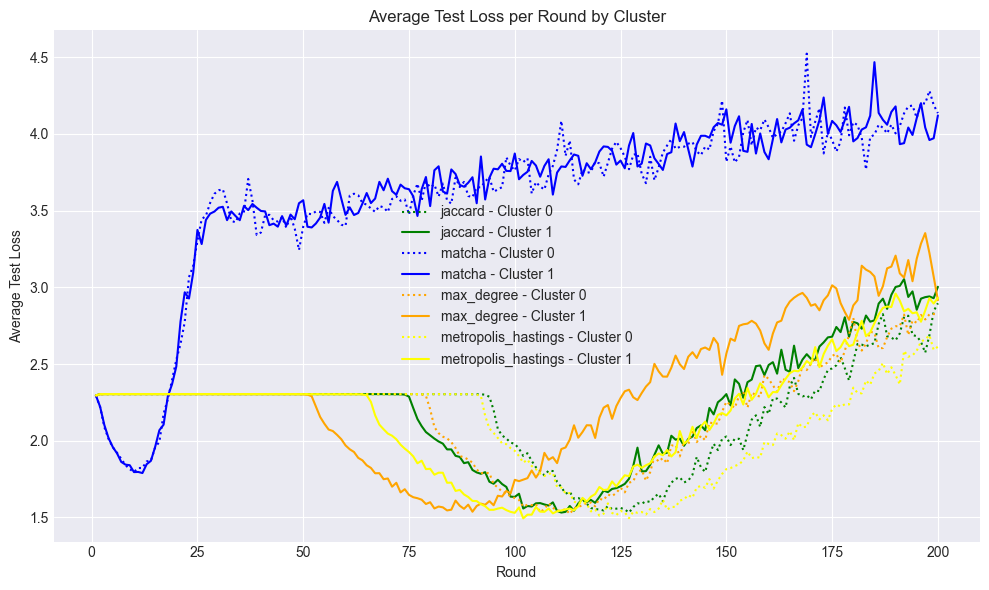

In [162]:
import matplotlib.pyplot as plt

methods = [
    ("jaccard", jaccard_p2p_metrics_df, "green"),
    ("matcha", matcha_p2p_metrics_df, "blue"),
    ("max_degree", max_degree_p2p_metrics_df, "orange"),
    ("metropolis_hastings", metropolis_p2p_metrics_df, "yellow"),
]

plt.figure(figsize=(10,6))

for name, df, color in methods:
    df = df.sort_values("round")

    # Cluster 0 → dotted
    cluster_0 = df[df["cluster_id"] == 0].groupby("round")["test_loss"].mean().sort_index()
    plt.plot(cluster_0.index, cluster_0.values, linestyle=":", color=color, label=f"{name} - Cluster 0")

    # Cluster 1 → solid
    cluster_1 = df[df["cluster_id"] == 1].groupby("round")["test_loss"].mean().sort_index()
    plt.plot(cluster_1.index, cluster_1.values, linestyle="-", color=color, label=f"{name} - Cluster 1")

plt.xlabel("Round")
plt.ylabel("Average Test Loss")
plt.title("Average Test Loss per Round by Cluster")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


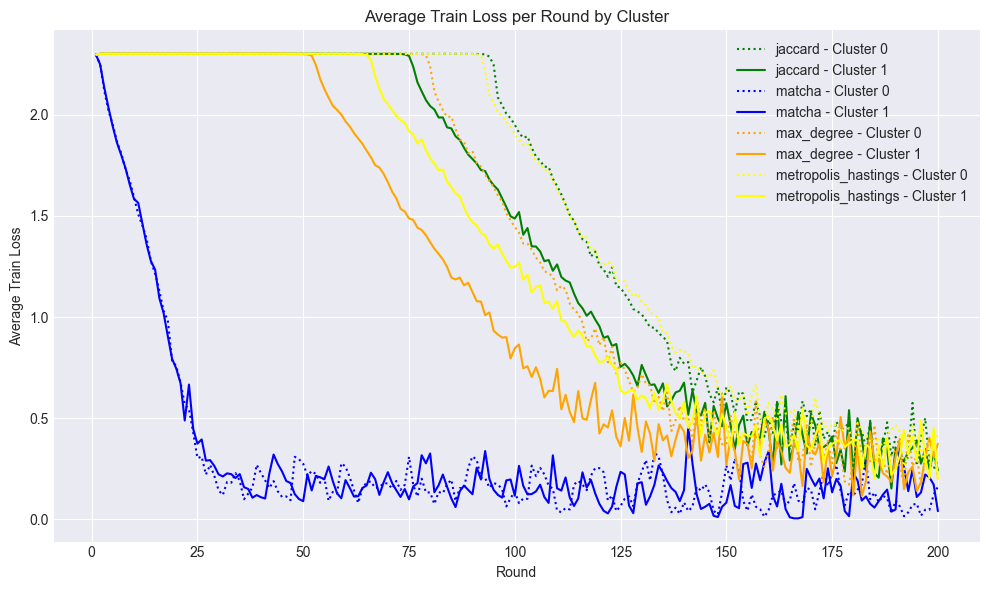

In [163]:
import matplotlib.pyplot as plt

methods = [
    ("jaccard", jaccard_p2p_metrics_df, "green"),
    ("matcha", matcha_p2p_metrics_df, "blue"),
    ("max_degree", max_degree_p2p_metrics_df, "orange"),
    ("metropolis_hastings", metropolis_p2p_metrics_df, "yellow"),
]

plt.figure(figsize=(10,6))

for name, df, color in methods:
    df = df.sort_values("round")

    # Cluster 0 → dotted
    cluster_0 = df[df["cluster_id"] == 0].groupby("round")["train_loss"].mean().sort_index()
    plt.plot(cluster_0.index, cluster_0.values, linestyle=":", color=color, label=f"{name} - Cluster 0")

    # Cluster 1 → solid
    cluster_1 = df[df["cluster_id"] == 1].groupby("round")["train_loss"].mean().sort_index()
    plt.plot(cluster_1.index, cluster_1.values, linestyle="-", color=color, label=f"{name} - Cluster 1")

plt.xlabel("Round")
plt.ylabel("Average Train Loss")
plt.title("Average Train Loss per Round by Cluster")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Avg gradient norm per round

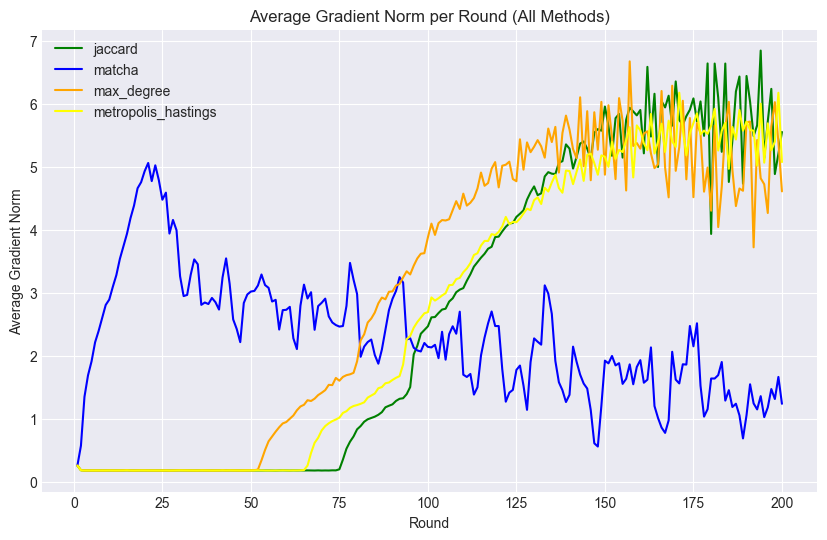

In [164]:
import matplotlib.pyplot as plt

methods = [
    ("jaccard", jaccard_p2p_metrics_df, "green"),
    ("matcha", matcha_p2p_metrics_df, "blue"),
    ("max_degree", max_degree_p2p_metrics_df, "orange"),
    ("metropolis_hastings", metropolis_p2p_metrics_df, "yellow"),
]

plt.figure(figsize=(10,6))

for name, df, color in methods:
    avg_grad_norm = df.groupby("round")["gradient_norm"].mean().sort_index()
    plt.plot(avg_grad_norm.index, avg_grad_norm.values, label=name, color=color)

plt.xlabel("Round")
plt.ylabel("Average Gradient Norm")
plt.title("Average Gradient Norm per Round (All Methods)")
plt.legend()
plt.grid(True)
plt.show()



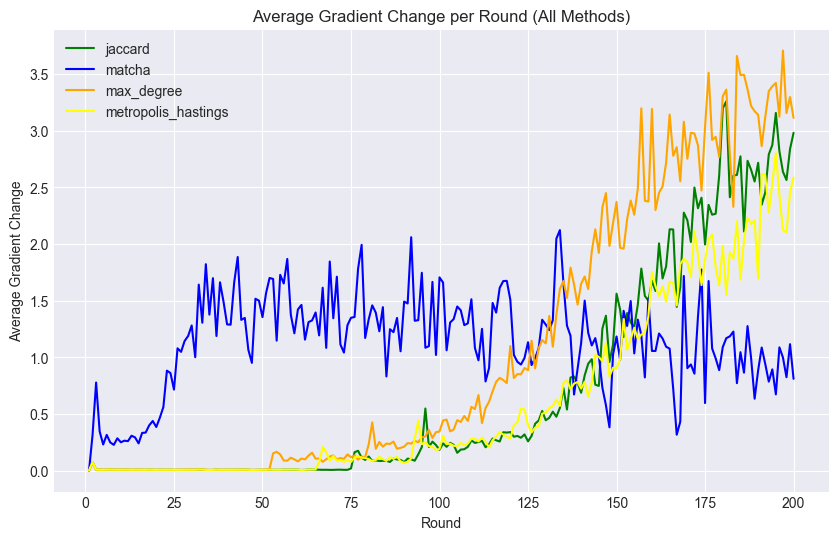

In [165]:
plt.figure(figsize=(10,6))

for name, df, color in methods:
    avg_grad_change = df.groupby("round")["gradient_change"].mean().sort_index()
    plt.plot(avg_grad_change.index, avg_grad_change.values, label=name, color=color)

plt.xlabel("Round")
plt.ylabel("Average Gradient Change")
plt.title("Average Gradient Change per Round (All Methods)")
plt.legend()
plt.grid(True)
plt.show()


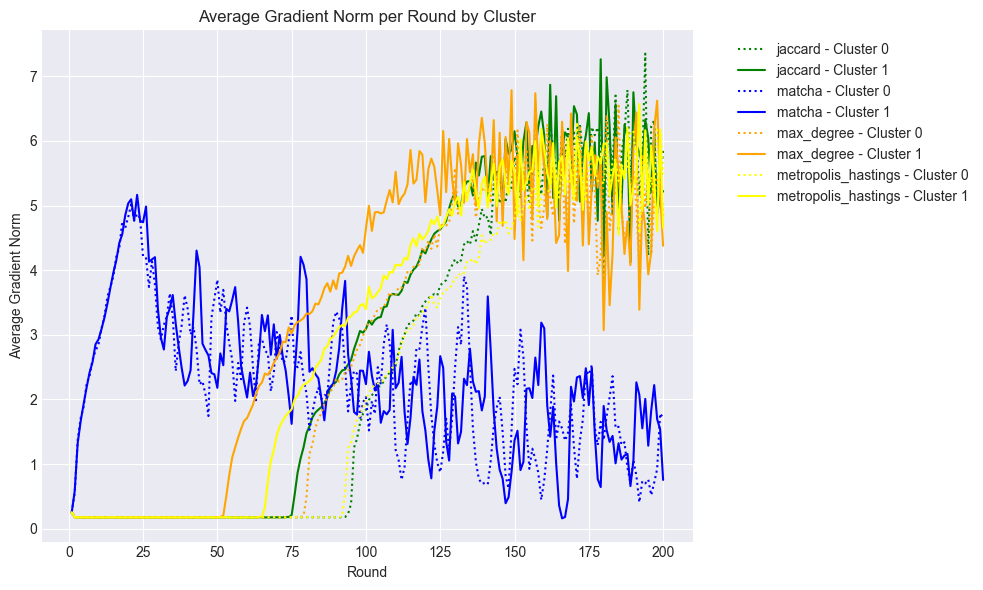

In [166]:
plt.figure(figsize=(10,6))

for name, df, color in methods:
    for cluster_id, linestyle in [(0, ":"), (1, "-")]:
        cluster_df = df[df["cluster_id"] == cluster_id].groupby("round")["gradient_norm"].mean().sort_index()
        plt.plot(cluster_df.index, cluster_df.values, color=color, linestyle=linestyle, label=f"{name} - Cluster {cluster_id}")

plt.xlabel("Round")
plt.ylabel("Average Gradient Norm")
plt.title("Average Gradient Norm per Round by Cluster")
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


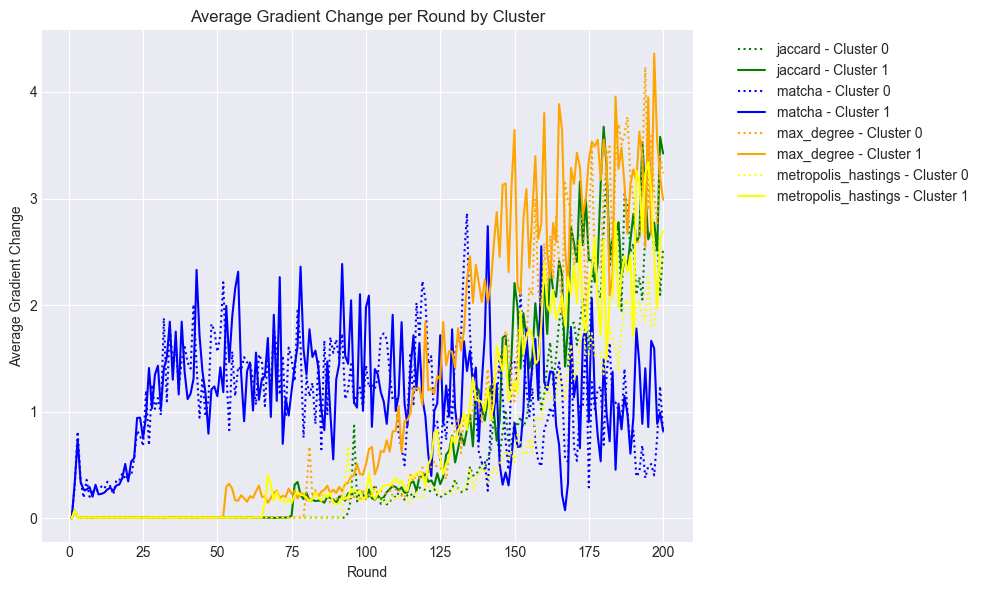

In [167]:
methods = [
    ("jaccard", jaccard_p2p_metrics_df, "green"),
    ("matcha", matcha_p2p_metrics_df, "blue"),
    ("max_degree", max_degree_p2p_metrics_df, "orange"),
    ("metropolis_hastings", metropolis_p2p_metrics_df, "yellow"),
]

plt.figure(figsize=(10,6))

for name, df, color in methods:
    for cluster_id, linestyle in [(0, ":"), (1, "-")]:
        cluster_df = df[df["cluster_id"] == cluster_id].groupby("round")["gradient_change"].mean().sort_index()
        plt.plot(cluster_df.index, cluster_df.values, color=color, linestyle=linestyle, label=f"{name} - Cluster {cluster_id}")

plt.xlabel("Round")
plt.ylabel("Average Gradient Change")
plt.title("Average Gradient Change per Round by Cluster")
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

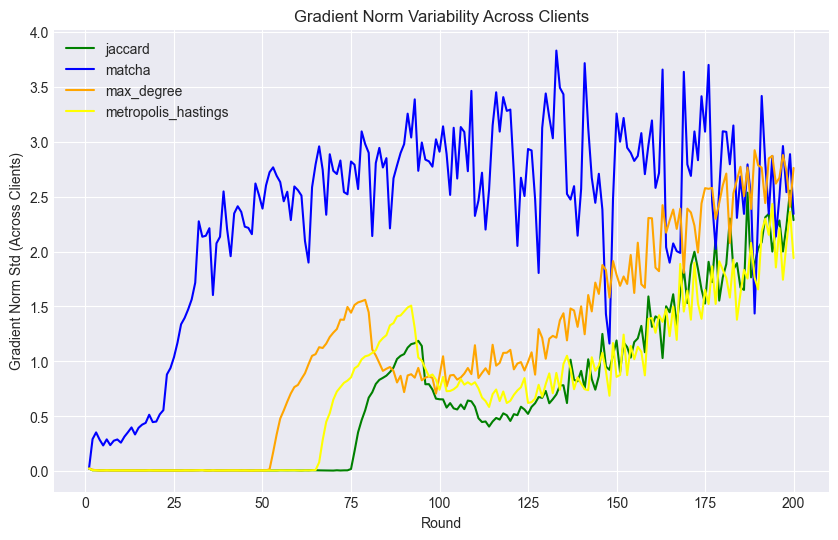

In [168]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

methods = [
    ("jaccard", jaccard_p2p_metrics_df, "green"),
    ("matcha", matcha_p2p_metrics_df, "blue"),
    ("max_degree", max_degree_p2p_metrics_df, "orange"),
    ("metropolis_hastings", metropolis_p2p_metrics_df, "yellow"),
]

plt.figure(figsize=(10,6))

for name, df, color in methods:
    grad_std = (
        df.groupby("round")["gradient_norm"]
        .std()
        .sort_index()
    )
    plt.plot(grad_std.index, grad_std.values,
             color=color, label=name)

plt.xlabel("Round")
plt.ylabel("Gradient Norm Std (Across Clients)")
plt.title("Gradient Norm Variability Across Clients")
plt.legend()
plt.grid(True)
plt.show()


## Average F1 Score per Class (All Methods)

In [169]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

methods = [
    ("jaccard", jaccard_p2p_per_class_df, "green"),
    ("matcha", matcha_p2p_per_class_df, "blue"),
    ("max_degree", max_degree_p2p_per_class_df, "orange"),
    ("metropolis_hastings", metropolis_p2p_per_class_df, "yellow"),
]

# Create subplots: 2 rows x 2 columns
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=[name.replace('_', ' ').title() for name, _, _ in methods],
    vertical_spacing=0.12,
    horizontal_spacing=0.1
)

# Position mapping for subplots
positions = [(1, 1), (1, 2), (2, 1), (2, 2)]

for (name, df, color), (row, col) in zip(methods, positions):
    print(f"\n{name.upper()}:")
    print(f"Shape: {df.shape}")
    print(f"Columns: {df.columns.tolist()}")
    
    if "round" in df.columns and "class_id" in df.columns and "class_f1_score" in df.columns:
        final_round = df["round"].max()
        print(f"Final round: {final_round}")
        
        avg_f1 = (
            df[df["round"] == final_round]
            .groupby("class_id")["class_f1_score"]
            .mean()
            .sort_index()
        )
        
        print(f"Classes: {len(avg_f1)}")
        print(f"F1 range: {avg_f1.min():.4f} to {avg_f1.max():.4f}")
        
        fig.add_trace(
            go.Scatter(
                x=avg_f1.index,
                y=avg_f1.values,
                mode='lines+markers',
                name=name.replace('_', ' ').title(),
                line=dict(color=color, width=2),
                marker=dict(size=6, color=color),
                showlegend=False
            ),
            row=row, col=col
        )
    else:
        print(f"WARNING: Missing required columns!")

# Update axes labels
fig.update_xaxes(title_text="Class ID", row=2, col=1)
fig.update_xaxes(title_text="Class ID", row=2, col=2)
fig.update_yaxes(title_text="Average F1 Score", row=1, col=1)
fig.update_yaxes(title_text="Average F1 Score", row=2, col=1)

# Update layout
fig.update_layout(
    title_text="Final Round Average F1 Score per Class",
    height=800,
    width=1200,
    template='plotly_white',
    font=dict(size=11)
)

fig.show()


JACCARD:
Shape: (80000, 8)
Columns: ['client_id', 'round', 'cluster_id', 'class_id', 'class_accuracy', 'class_precision', 'class_recall', 'class_f1_score']
Final round: 200
Classes: 10
F1 range: 29.9229 to 61.9329

MATCHA:
Shape: (80000, 8)
Columns: ['client_id', 'round', 'cluster_id', 'class_id', 'class_accuracy', 'class_precision', 'class_recall', 'class_f1_score']
Final round: 200
Classes: 10
F1 range: 21.6476 to 42.8823

MAX_DEGREE:
Shape: (80000, 8)
Columns: ['client_id', 'round', 'cluster_id', 'class_id', 'class_accuracy', 'class_precision', 'class_recall', 'class_f1_score']
Final round: 200
Classes: 10
F1 range: 30.2251 to 63.4346

METROPOLIS_HASTINGS:
Shape: (80000, 8)
Columns: ['client_id', 'round', 'cluster_id', 'class_id', 'class_accuracy', 'class_precision', 'class_recall', 'class_f1_score']
Final round: 200
Classes: 10
F1 range: 30.5854 to 63.4488


## Per-Class Accuracy Over Rounds

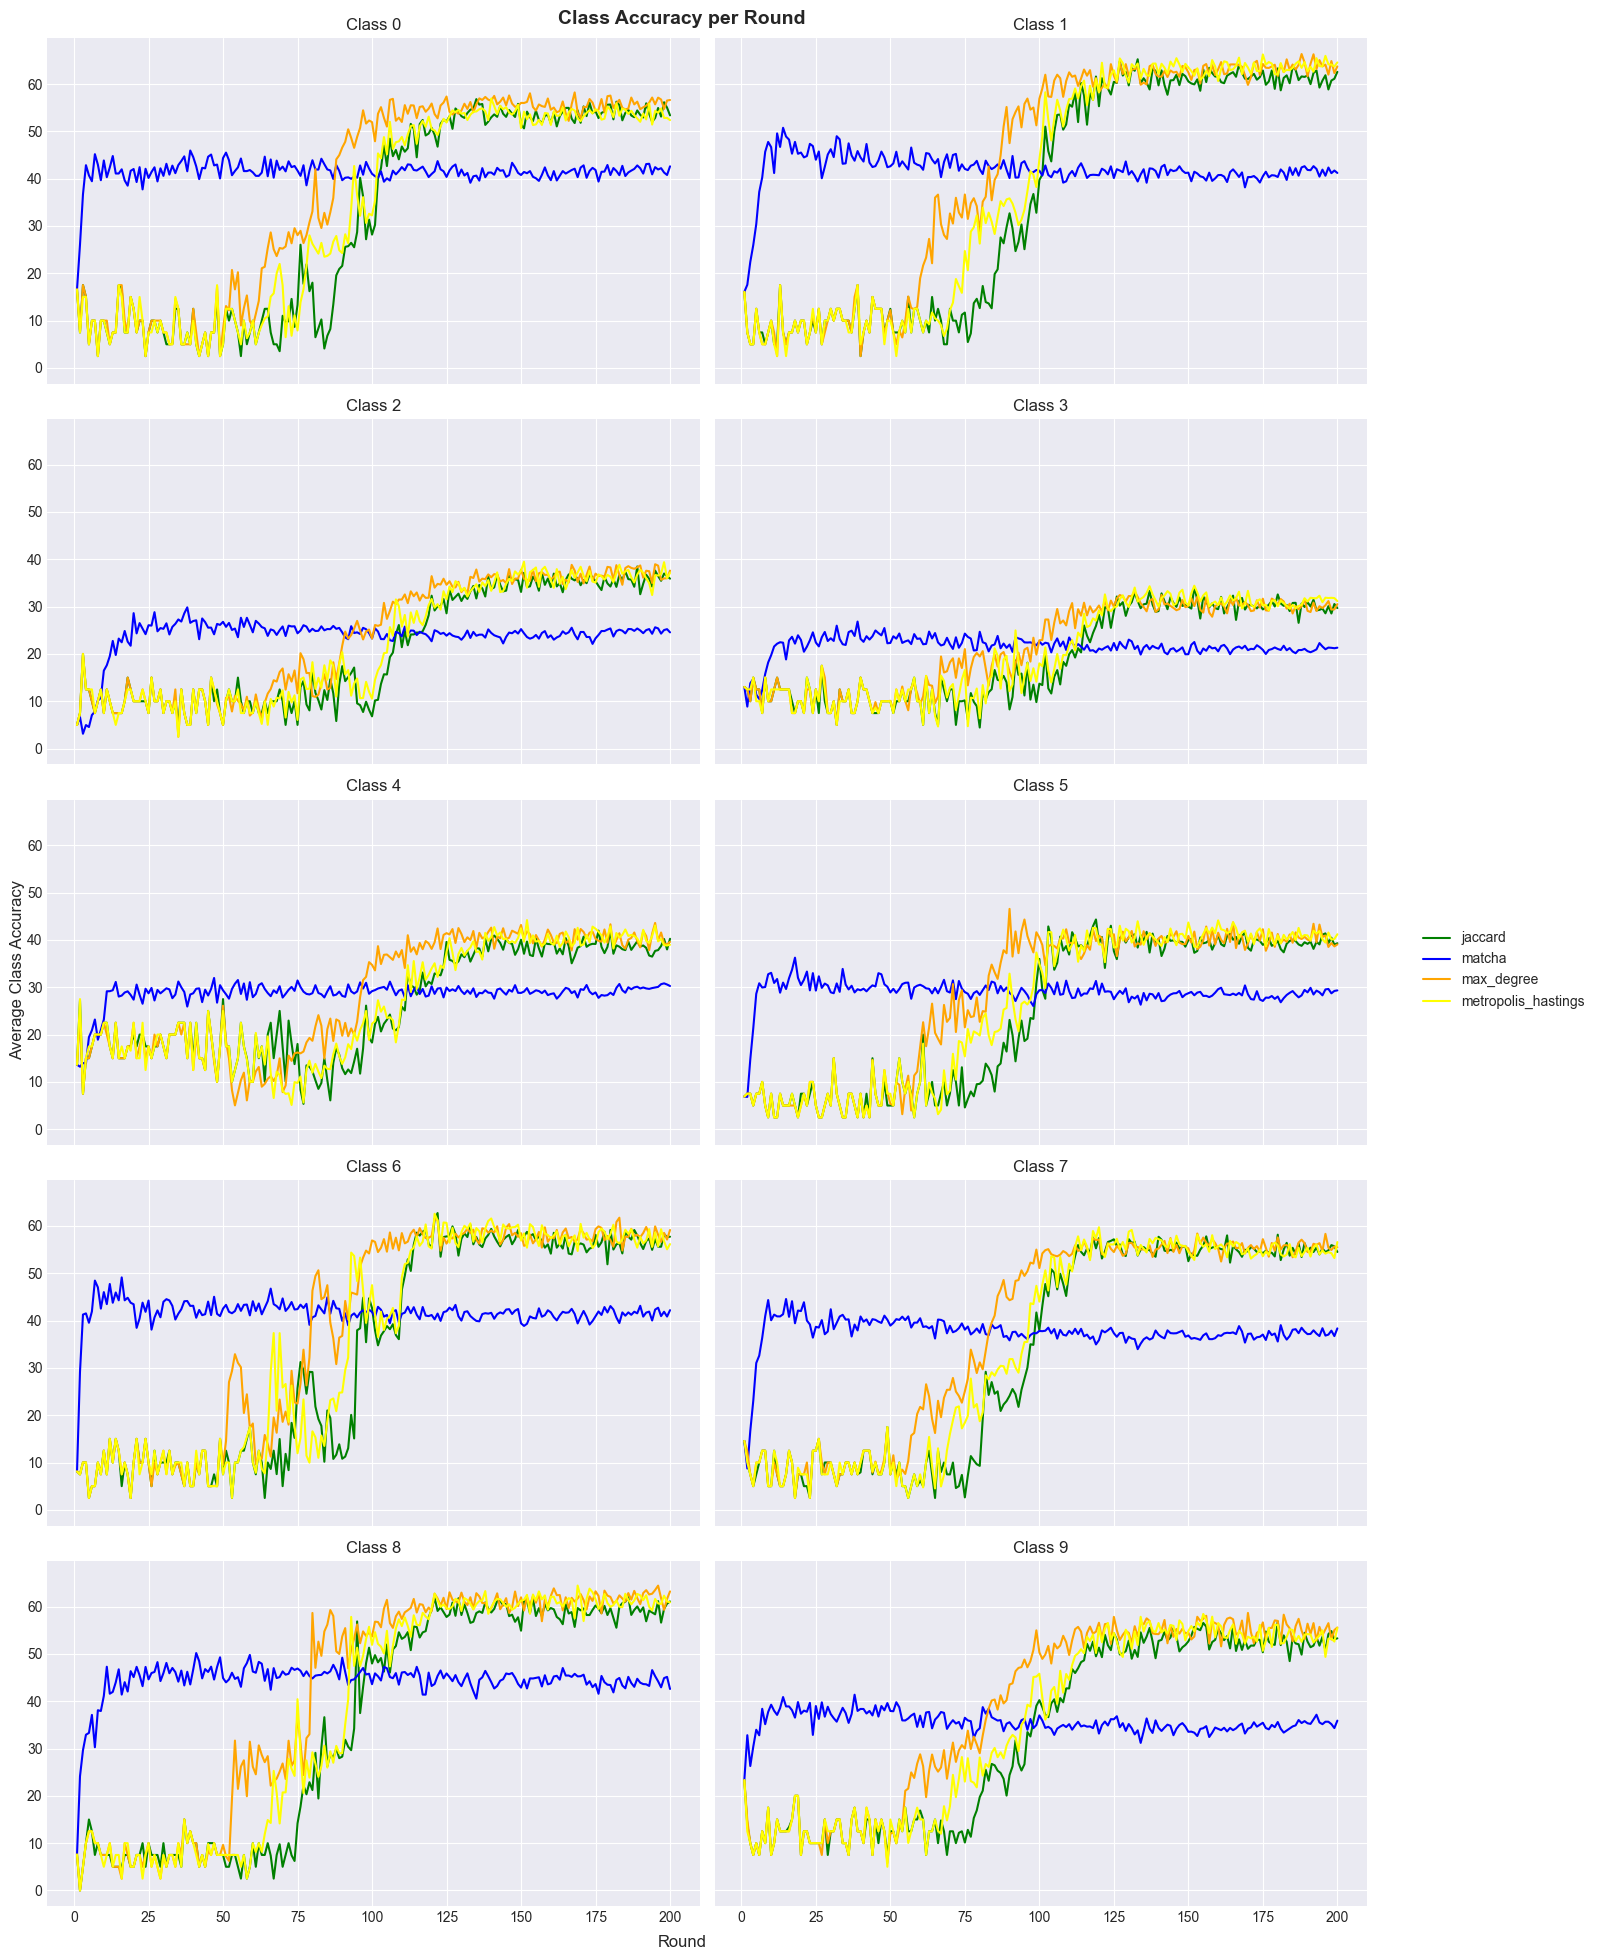

In [170]:
from matplotlib.figure import Figure

selected_class = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

n_classes = len(selected_class)
n_cols = 2
n_rows = (n_classes + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 4 * n_rows), sharex=True, sharey=True)
axes = np.atleast_1d(axes).ravel()

for ax, class_id in zip(axes, selected_class):
    for name, df, color in methods:
        class_df = (
            df[df["class_id"] == class_id]
            .groupby("round")["class_accuracy"]
            .mean()
            .sort_index()
        )
        ax.plot(class_df.index, class_df.values, color=color, label=name)

    ax.set_title(f"Class {class_id}")
    ax.grid(True)

for ax in axes[len(selected_class):]:
    ax.set_visible(False)

fig.suptitle("Class Accuracy per Round", fontsize=14, fontweight="bold")
fig.supxlabel("Round")
fig.supylabel("Average Class Accuracy")
fig.legend([name for name, _, _ in methods], loc="upper right", bbox_to_anchor=(0.98, 0.98))
plt.tight_layout()
plt.show()


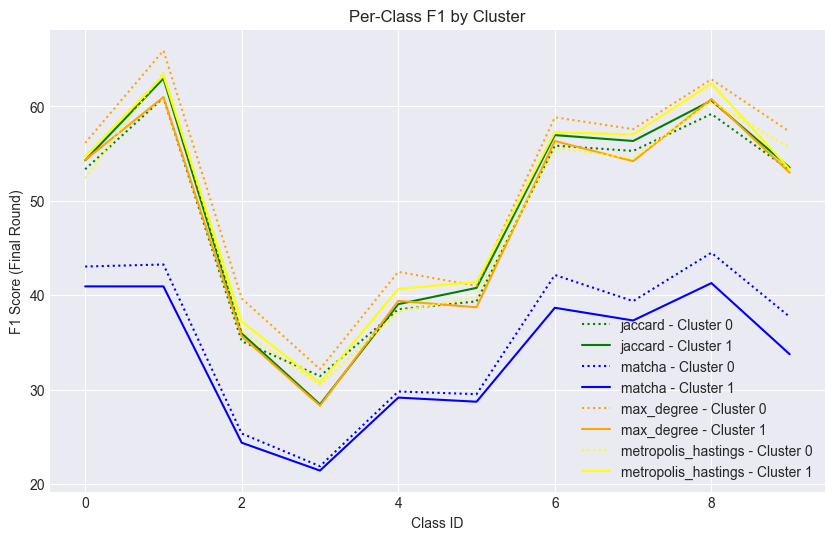

In [171]:
plt.figure(figsize=(10,6))

for name, df, color in methods:
    final_round = df["round"].max()

    for cluster_id, linestyle in [(0, ":"), (1, "-")]:
        cluster_f1 = (
            df[(df["round"] == final_round) & (df["cluster_id"] == cluster_id)]
            .groupby("class_id")["class_f1_score"]
            .mean()
            .sort_index()
        )

        plt.plot(
            cluster_f1.index,
            cluster_f1.values,
            color=color,
            linestyle=linestyle,
            label=f"{name} - Cluster {cluster_id}"
        )

plt.xlabel("Class ID")
plt.ylabel("F1 Score (Final Round)")
plt.title("Per-Class F1 by Cluster")
plt.legend()
plt.grid(True)
plt.show()


## 4. Gradient Changes per Client

## Client Accuracy Variance per Round (Consensus Convergence)
Lower variance = clients agree more = better propagation through the network.

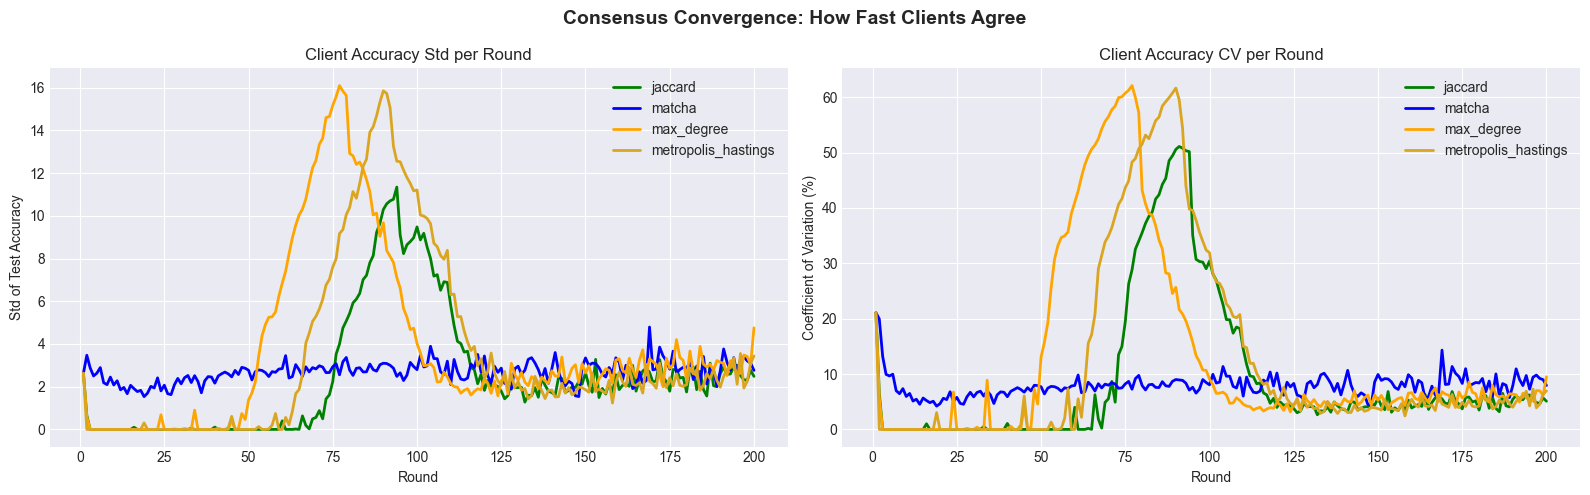

In [173]:
methods_plot = [
    ("jaccard", jaccard_p2p_metrics_df, "green"),
    ("matcha", matcha_p2p_metrics_df, "blue"),
    ("max_degree", max_degree_p2p_metrics_df, "orange"),
    ("metropolis_hastings", metropolis_p2p_metrics_df, "goldenrod"),
]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

for name, df, color in methods_plot:
    grouped = df.groupby('round')['test_accuracy']

    # Std
    std = grouped.std().sort_index()
    ax1.plot(std.index, std.values, color=color, label=name, linewidth=2)

    # Coefficient of variation (std / mean)
    mean = grouped.mean().sort_index()
    cv = (std / mean * 100).sort_index()
    ax2.plot(cv.index, cv.values, color=color, label=name, linewidth=2)

ax1.set_xlabel('Round')
ax1.set_ylabel('Std of Test Accuracy')
ax1.set_title('Client Accuracy Std per Round')
ax1.legend()
ax1.grid(True)

ax2.set_xlabel('Round')
ax2.set_ylabel('Coefficient of Variation (%)')
ax2.set_title('Client Accuracy CV per Round')
ax2.legend()
ax2.grid(True)

plt.suptitle('Consensus Convergence: How Fast Clients Agree', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## Inter-Cluster Accuracy Gap
|Cluster0_avg - Cluster1_avg| — measures how fast knowledge crosses the bridge link between clusters.

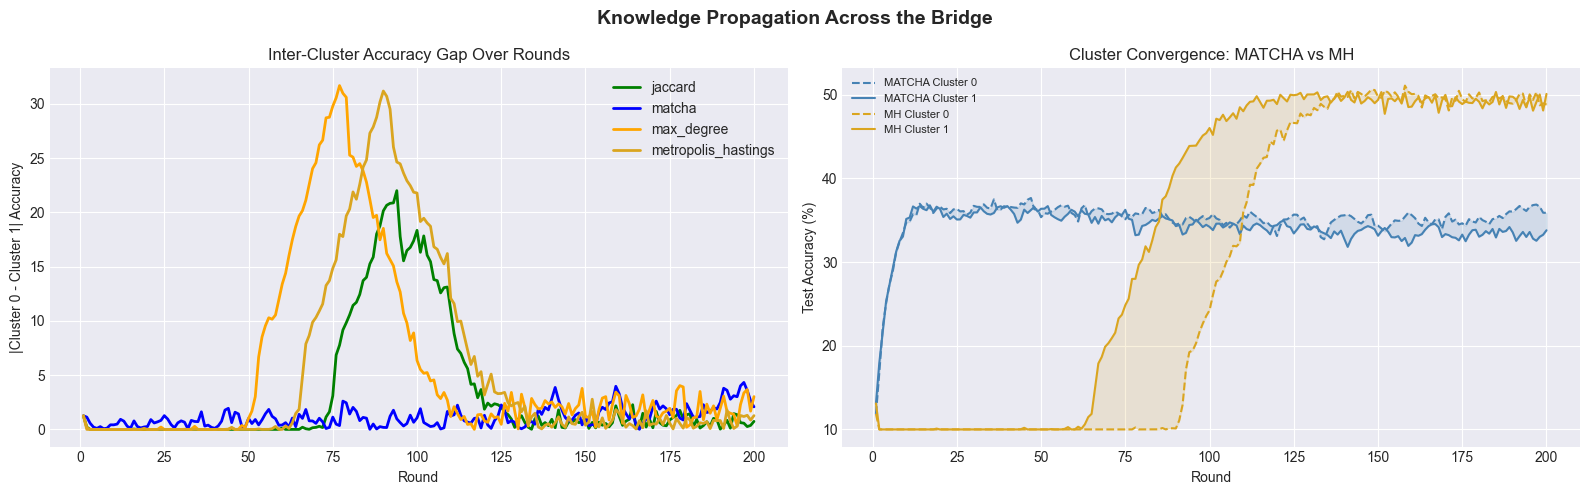

In [174]:
methods_plot = [
    ("jaccard", jaccard_p2p_metrics_df, "green"),
    ("matcha", matcha_p2p_metrics_df, "blue"),
    ("max_degree", max_degree_p2p_metrics_df, "orange"),
    ("metropolis_hastings", metropolis_p2p_metrics_df, "goldenrod"),
]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

for name, df, color in methods_plot:
    cluster_0_avg = df[df['cluster_id'] == 0].groupby('round')['test_accuracy'].mean().sort_index()
    cluster_1_avg = df[df['cluster_id'] == 1].groupby('round')['test_accuracy'].mean().sort_index()

    # Absolute gap
    gap = (cluster_0_avg - cluster_1_avg).abs()
    ax1.plot(gap.index, gap.values, color=color, label=name, linewidth=2)

    # Both cluster curves for one representative method (matcha)
    if name == 'matcha':
        ax2.plot(cluster_0_avg.index, cluster_0_avg.values, color='steelblue', linestyle='--', label='MATCHA Cluster 0')
        ax2.plot(cluster_1_avg.index, cluster_1_avg.values, color='steelblue', linestyle='-', label='MATCHA Cluster 1')
        ax2.fill_between(cluster_0_avg.index,
                         cluster_0_avg.values, cluster_1_avg.values,
                         alpha=0.15, color='steelblue')
    if name == 'metropolis_hastings':
        ax2.plot(cluster_0_avg.index, cluster_0_avg.values, color='goldenrod', linestyle='--', label='MH Cluster 0')
        ax2.plot(cluster_1_avg.index, cluster_1_avg.values, color='goldenrod', linestyle='-', label='MH Cluster 1')
        ax2.fill_between(cluster_0_avg.index,
                         cluster_0_avg.values, cluster_1_avg.values,
                         alpha=0.15, color='goldenrod')

ax1.set_xlabel('Round')
ax1.set_ylabel('|Cluster 0 - Cluster 1| Accuracy')
ax1.set_title('Inter-Cluster Accuracy Gap Over Rounds')
ax1.legend()
ax1.grid(True)

ax2.set_xlabel('Round')
ax2.set_ylabel('Test Accuracy (%)')
ax2.set_title('Cluster Convergence: MATCHA vs MH')
ax2.legend(fontsize=8)
ax2.grid(True)

plt.suptitle('Knowledge Propagation Across the Bridge', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## Generalization Gap (Train - Test Accuracy)
Positive gap = overfitting. If gossip mixing acts as regularization, the gap should shrink compared to local-only training.

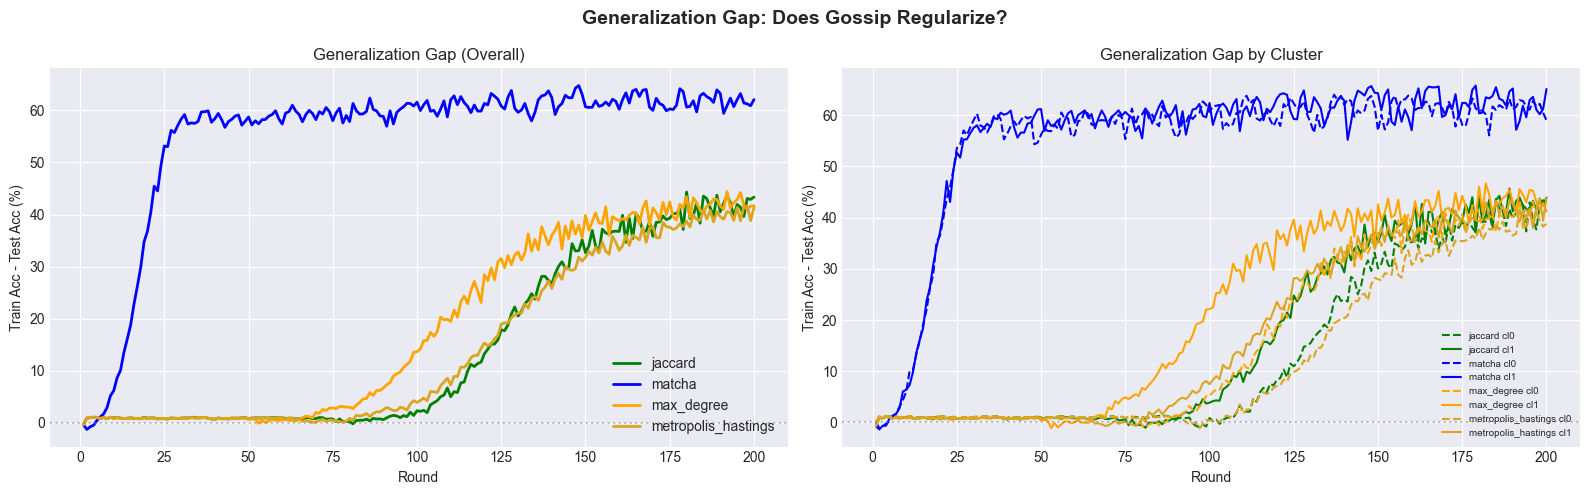

In [175]:
methods_plot = [
    ("jaccard", jaccard_p2p_metrics_df, "green"),
    ("matcha", matcha_p2p_metrics_df, "blue"),
    ("max_degree", max_degree_p2p_metrics_df, "orange"),
    ("metropolis_hastings", metropolis_p2p_metrics_df, "goldenrod"),
]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

for name, df, color in methods_plot:
    grouped = df.groupby('round').mean(numeric_only=True).sort_index()

    if 'train_accuracy' in grouped.columns:
        gap = grouped['train_accuracy'] - grouped['test_accuracy']
        ax1.plot(gap.index, gap.values, color=color, label=name, linewidth=2)

        # Per-cluster gap
        for cluster_id, ls in [(0, '--'), (1, '-')]:
            cg = df[df['cluster_id'] == cluster_id].groupby('round').mean(numeric_only=True).sort_index()
            if 'train_accuracy' in cg.columns:
                cluster_gap = cg['train_accuracy'] - cg['test_accuracy']
                ax2.plot(cluster_gap.index, cluster_gap.values,
                         color=color, linestyle=ls, label=f"{name} cl{cluster_id}")

ax1.set_xlabel('Round')
ax1.set_ylabel('Train Acc - Test Acc (%)')
ax1.set_title('Generalization Gap (Overall)')
ax1.axhline(y=0, color='gray', linestyle=':', alpha=0.5)
ax1.legend()
ax1.grid(True)

ax2.set_xlabel('Round')
ax2.set_ylabel('Train Acc - Test Acc (%)')
ax2.set_title('Generalization Gap by Cluster')
ax2.axhline(y=0, color='gray', linestyle=':', alpha=0.5)
ax2.legend(fontsize=7)
ax2.grid(True)

plt.suptitle('Generalization Gap: Does Gossip Regularize?', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## Gradient Change: Bridge vs Interior Clients
Bridge clients (those connected to both clusters) should exhibit larger gradient changes from gossip, proving model propagation across the network bottleneck.

Using heuristic bridge clients: [0, 20]


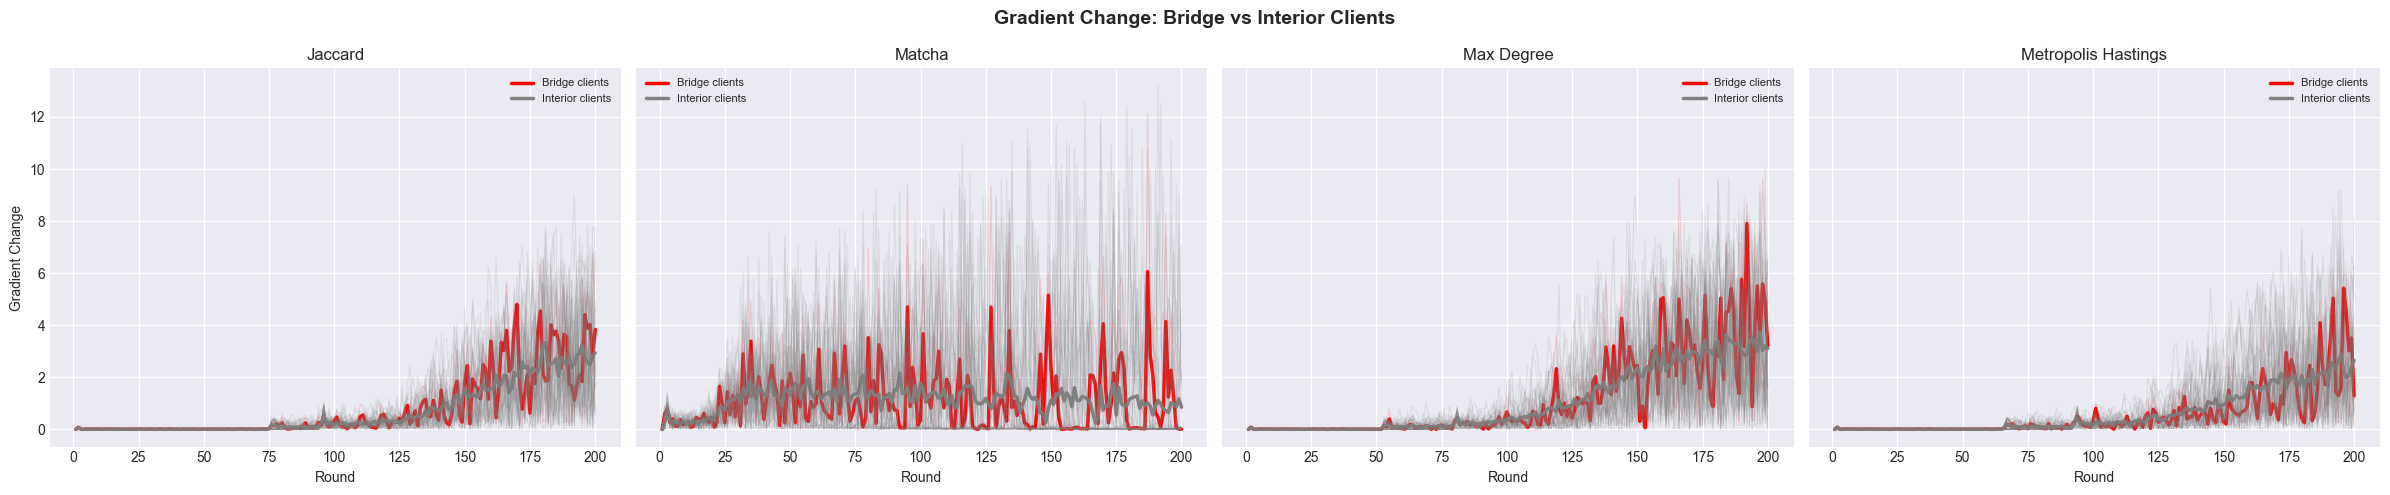


Bridge vs Interior gradient change (final round avg):
  jaccard                  : bridge=3.8342  interior=2.9358  ratio=1.31x
  matcha                   : bridge=0.0094  interior=0.8517  ratio=0.01x
  max_degree               : bridge=3.1989  interior=3.1078  ratio=1.03x
  metropolis_hastings      : bridge=1.2860  interior=2.6561  ratio=0.48x


In [176]:
import pickle, networkx as nx

# Try to load the shared topology to identify bridge clients
bridge_clients = set()
try:
    with open('shared_topology.pkl', 'rb') as f:
        graph = pickle.load(f)
    # Bridge clients = nodes with at least one neighbor in a different cluster
    for node in graph.nodes():
        node_cluster = graph.nodes[node].get('cluster', None)
        for neighbor in graph.neighbors(node):
            neighbor_cluster = graph.nodes[neighbor].get('cluster', None)
            if node_cluster is not None and neighbor_cluster is not None and node_cluster != neighbor_cluster:
                bridge_clients.add(node)
                break
    print(f"Bridge clients (cross-cluster edges): {sorted(bridge_clients)}")
except:
    # Fallback: first client of each cluster (cluster centers)
    bridge_clients = {0, 20}
    print(f"Using heuristic bridge clients: {sorted(bridge_clients)}")

methods_plot = [
    ("jaccard", jaccard_p2p_metrics_df, "green"),
    ("matcha", matcha_p2p_metrics_df, "blue"),
    ("max_degree", max_degree_p2p_metrics_df, "orange"),
    ("metropolis_hastings", metropolis_p2p_metrics_df, "goldenrod"),
]

fig, axes = plt.subplots(1, len(methods_plot), figsize=(6 * len(methods_plot), 5), sharey=True)
if len(methods_plot) == 1:
    axes = [axes]

for ax, (name, df, color) in zip(axes, methods_plot):
    # Separate bridge vs interior clients
    bridge_df = df[df['client_id'].isin(bridge_clients)].groupby('round')['gradient_change'].mean().sort_index()
    interior_df = df[~df['client_id'].isin(bridge_clients)].groupby('round')['gradient_change'].mean().sort_index()

    ax.plot(bridge_df.index, bridge_df.values, color='red', linewidth=2.5, label='Bridge clients')
    ax.plot(interior_df.index, interior_df.values, color='gray', linewidth=2.5, label='Interior clients')

    # Show individual client traces faintly
    for cid in df['client_id'].unique():
        c_data = df[df['client_id'] == cid].sort_values('round')
        c_color = 'red' if cid in bridge_clients else 'gray'
        ax.plot(c_data['round'], c_data['gradient_change'], color=c_color, alpha=0.15, linewidth=0.8)

    ax.set_title(name.replace('_', ' ').title())
    ax.set_xlabel('Round')
    ax.legend(fontsize=8)
    ax.grid(True)

axes[0].set_ylabel('Gradient Change')
fig.suptitle('Gradient Change: Bridge vs Interior Clients', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Print summary
print("\nBridge vs Interior gradient change (final round avg):")
for name, df, _ in methods_plot:
    final_r = df['round'].max()
    final = df[df['round'] == final_r]
    bridge_avg = final[final['client_id'].isin(bridge_clients)]['gradient_change'].mean()
    interior_avg = final[~final['client_id'].isin(bridge_clients)]['gradient_change'].mean()
    ratio = bridge_avg / interior_avg if interior_avg > 0 else float('inf')
    print(f"  {name:25s}: bridge={bridge_avg:.4f}  interior={interior_avg:.4f}  ratio={ratio:.2f}x")

## Edge (Bridge) vs Interior Clients: Test Accuracy
Compares the accuracy trajectory of clients that sit at the cluster boundary (with cross-cluster edges) against purely interior clients. Faster convergence of edge clients indicates effective model propagation through the bottleneck.

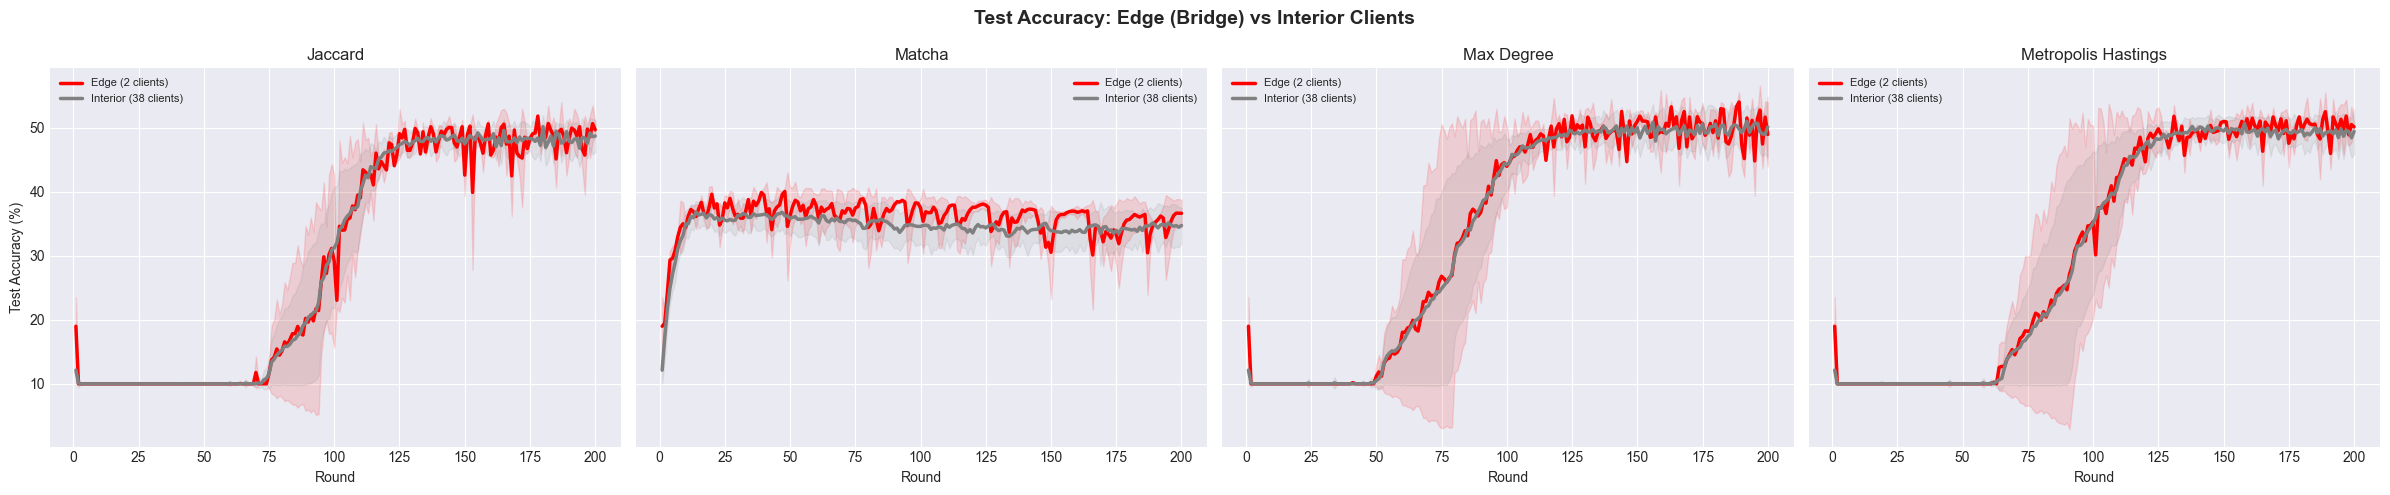

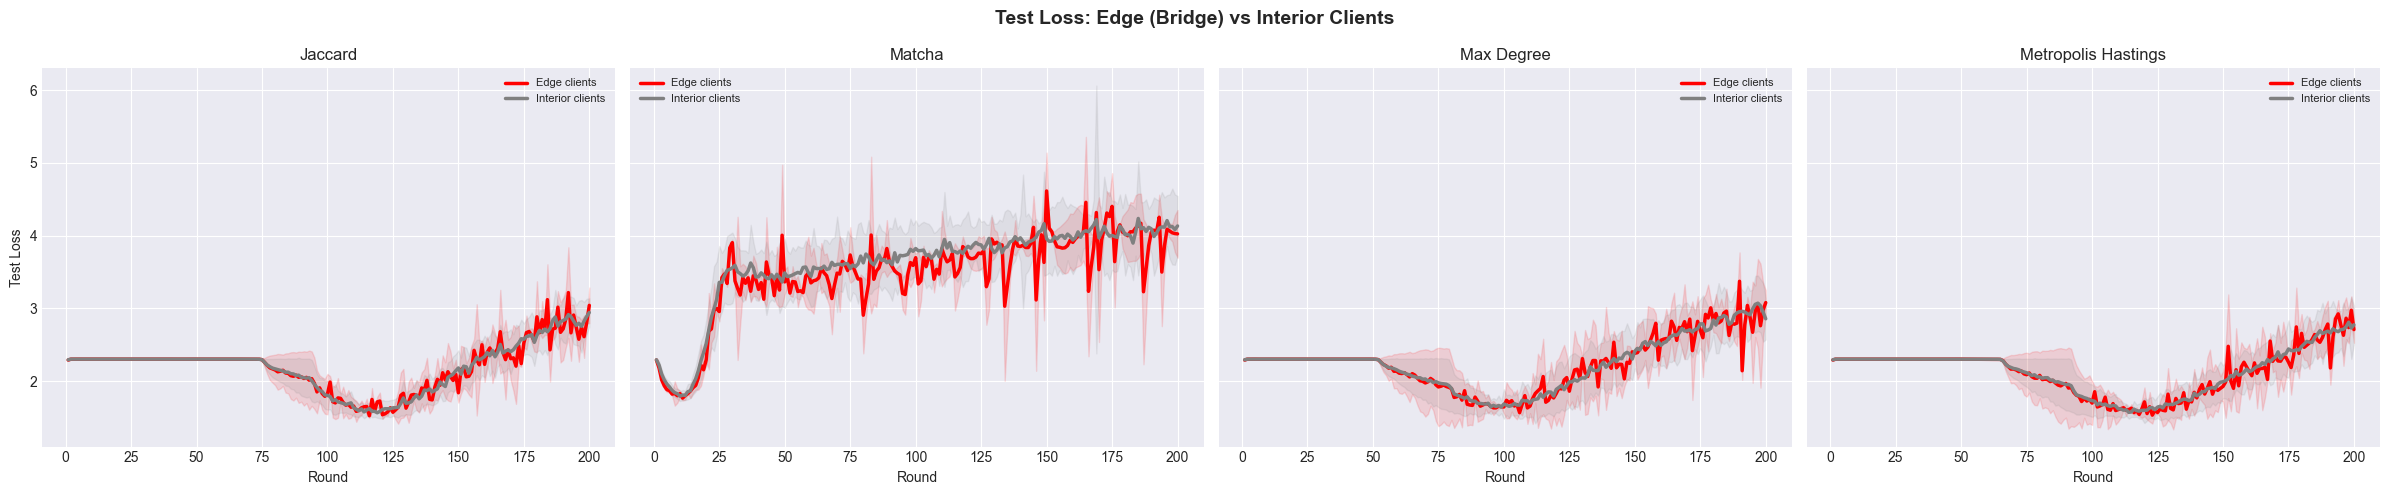


Edge clients: [0, 20]

Final-round comparison (Edge vs Interior):
Method                      Edge Acc    Int Acc    Δ Acc  Edge Loss   Int Loss
---------------------------------------------------------------------------
jaccard                       49.68%     48.72%   +0.96%     3.0423     2.9448
matcha                        36.64%     34.74%   +1.90%     4.0246     4.1333
max_degree                    48.96%     50.11%   -1.15%     3.0805     2.8586
metropolis_hastings           50.14%     49.42%   +0.72%     2.7097     2.7757


In [177]:
methods_plot = [
    ("jaccard", jaccard_p2p_metrics_df, "green"),
    ("matcha", matcha_p2p_metrics_df, "blue"),
    ("max_degree", max_degree_p2p_metrics_df, "orange"),
    ("metropolis_hastings", metropolis_p2p_metrics_df, "goldenrod"),
]

# --- 1) Test Accuracy: Edge vs Interior ---
fig, axes = plt.subplots(1, len(methods_plot), figsize=(6 * len(methods_plot), 5), sharey=True)
if len(methods_plot) == 1:
    axes = [axes]

for ax, (name, df, color) in zip(axes, methods_plot):
    edge_acc = df[df['client_id'].isin(bridge_clients)].groupby('round')['test_accuracy'].agg(['mean', 'std']).sort_index()
    interior_acc = df[~df['client_id'].isin(bridge_clients)].groupby('round')['test_accuracy'].agg(['mean', 'std']).sort_index()

    ax.plot(edge_acc.index, edge_acc['mean'], color='red', linewidth=2.5, label=f'Edge ({len(bridge_clients)} clients)')
    ax.fill_between(edge_acc.index,
                     edge_acc['mean'] - edge_acc['std'],
                     edge_acc['mean'] + edge_acc['std'],
                     color='red', alpha=0.12)

    n_interior = df['client_id'].nunique() - len(bridge_clients)
    ax.plot(interior_acc.index, interior_acc['mean'], color='gray', linewidth=2.5, label=f'Interior ({n_interior} clients)')
    ax.fill_between(interior_acc.index,
                     interior_acc['mean'] - interior_acc['std'],
                     interior_acc['mean'] + interior_acc['std'],
                     color='gray', alpha=0.12)

    ax.set_title(name.replace('_', ' ').title())
    ax.set_xlabel('Round')
    ax.legend(fontsize=8)
    ax.grid(True)

axes[0].set_ylabel('Test Accuracy (%)')
fig.suptitle('Test Accuracy: Edge (Bridge) vs Interior Clients', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# --- 2) Test Loss: Edge vs Interior ---
fig2, axes2 = plt.subplots(1, len(methods_plot), figsize=(6 * len(methods_plot), 5), sharey=True)
if len(methods_plot) == 1:
    axes2 = [axes2]

for ax, (name, df, color) in zip(axes2, methods_plot):
    edge_loss = df[df['client_id'].isin(bridge_clients)].groupby('round')['test_loss'].agg(['mean', 'std']).sort_index()
    interior_loss = df[~df['client_id'].isin(bridge_clients)].groupby('round')['test_loss'].agg(['mean', 'std']).sort_index()

    ax.plot(edge_loss.index, edge_loss['mean'], color='red', linewidth=2.5, label='Edge clients')
    ax.fill_between(edge_loss.index,
                     edge_loss['mean'] - edge_loss['std'],
                     edge_loss['mean'] + edge_loss['std'],
                     color='red', alpha=0.12)

    ax.plot(interior_loss.index, interior_loss['mean'], color='gray', linewidth=2.5, label='Interior clients')
    ax.fill_between(interior_loss.index,
                     interior_loss['mean'] - interior_loss['std'],
                     interior_loss['mean'] + interior_loss['std'],
                     color='gray', alpha=0.12)

    ax.set_title(name.replace('_', ' ').title())
    ax.set_xlabel('Round')
    ax.legend(fontsize=8)
    ax.grid(True)

axes2[0].set_ylabel('Test Loss')
fig2.suptitle('Test Loss: Edge (Bridge) vs Interior Clients', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# --- 3) Summary table ---
print(f"\nEdge clients: {sorted(bridge_clients)}")
print(f"\nFinal-round comparison (Edge vs Interior):")
print(f"{'Method':<25s} {'Edge Acc':>10s} {'Int Acc':>10s} {'Δ Acc':>8s} {'Edge Loss':>10s} {'Int Loss':>10s}")
print("-" * 75)
for name, df, _ in methods_plot:
    final_r = df['round'].max()
    f = df[df['round'] == final_r]
    ea = f[f['client_id'].isin(bridge_clients)]['test_accuracy'].mean()
    ia = f[~f['client_id'].isin(bridge_clients)]['test_accuracy'].mean()
    el = f[f['client_id'].isin(bridge_clients)]['test_loss'].mean()
    il = f[~f['client_id'].isin(bridge_clients)]['test_loss'].mean()
    print(f"{name:<25s} {ea:>9.2f}% {ia:>9.2f}% {ea-ia:>+7.2f}% {el:>10.4f} {il:>10.4f}")

## Edge Client Head-to-Head: Accuracy & Loss
Direct comparison of the two bridge clients (one from each cluster). If propagation is effective, their trajectories should converge despite starting in separate clusters.

Edge client from Cluster 0: Client 0
Edge client from Cluster 1: Client 20


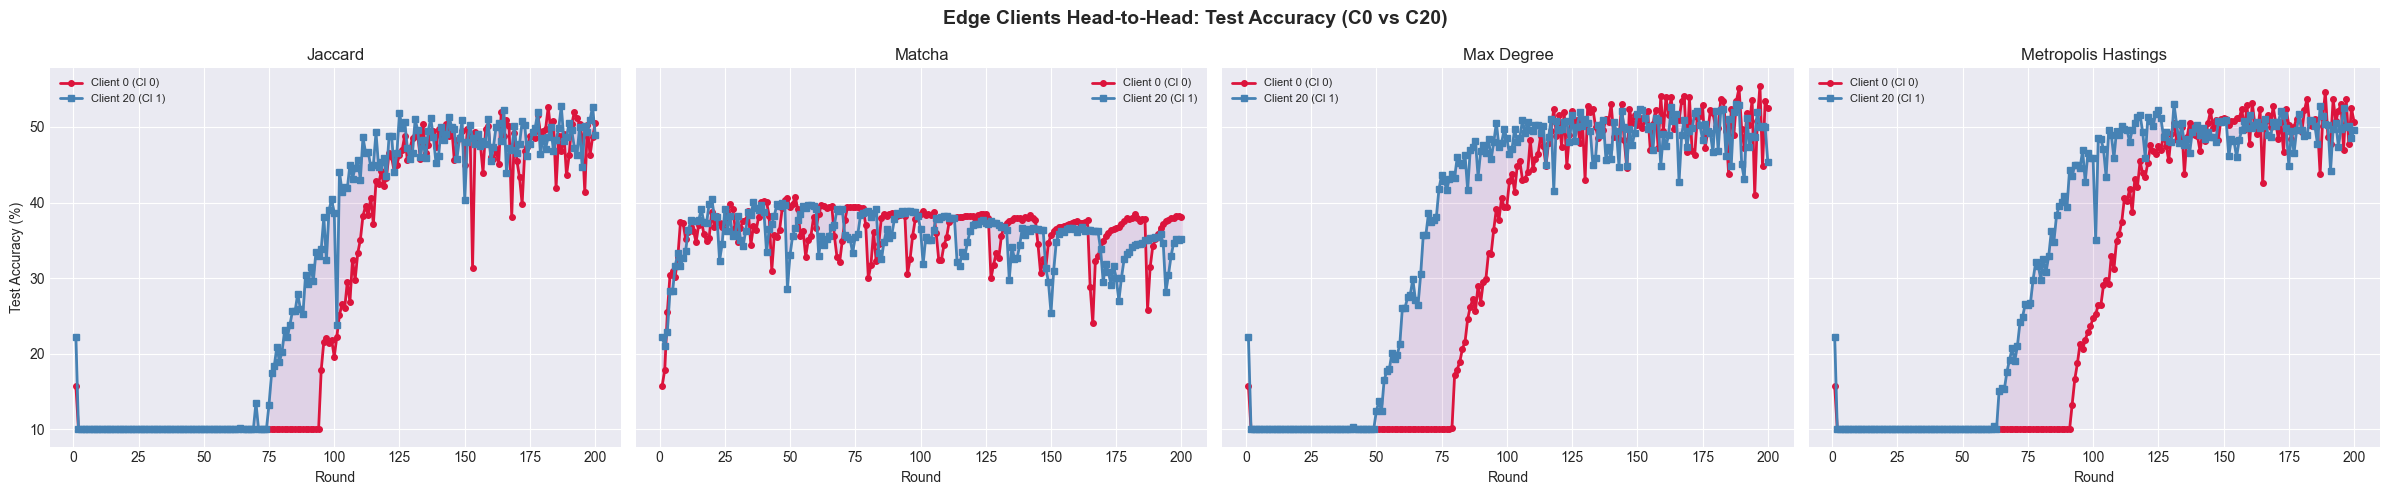

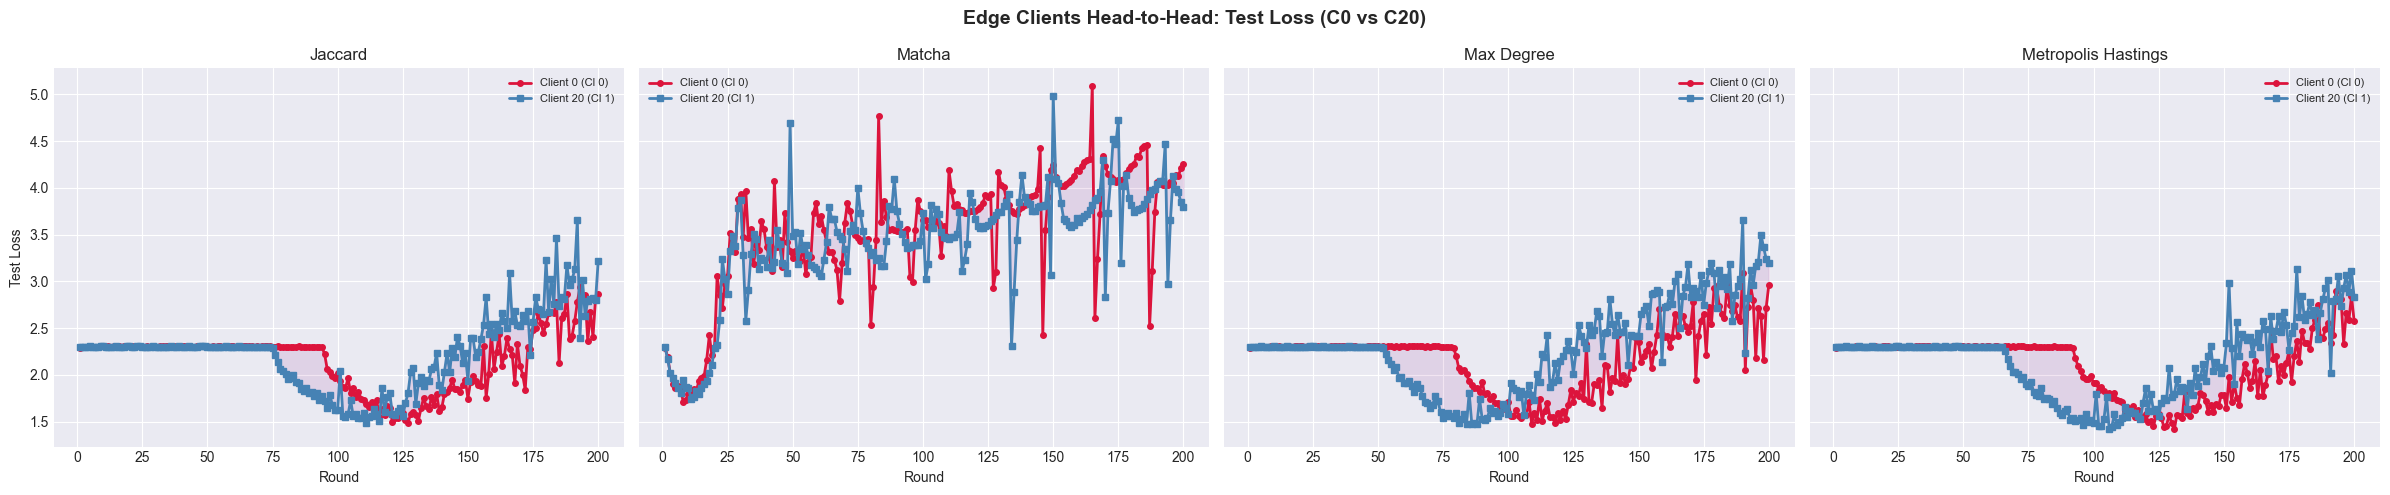


Edge client convergence (final round):
Method                        C0 Acc    C20 Acc    Δ Acc    C0 Loss   C20 Loss   Δ Loss
-------------------------------------------------------------------------------------
jaccard                       50.46%     48.90%    1.56%     2.8688     3.2157   0.3468
matcha                        38.15%     35.13%    3.02%     4.2562     3.7930   0.4632
max_degree                    52.50%     45.42%    7.08%     2.9593     3.2017   0.2424
metropolis_hastings           50.71%     49.57%    1.14%     2.5815     2.8379   0.2564


In [178]:
# Identify the two edge clients (one per cluster)
edge_per_cluster = {}
for cid in sorted(bridge_clients):
    # Determine cluster from any method's df
    cl = matcha_p2p_metrics_df[matcha_p2p_metrics_df['client_id'] == cid]['cluster_id'].iloc[0]
    if cl not in edge_per_cluster:
        edge_per_cluster[cl] = cid

edge_client_0 = edge_per_cluster.get(0, sorted(bridge_clients)[0])
edge_client_1 = edge_per_cluster.get(1, sorted(bridge_clients)[-1])
print(f"Edge client from Cluster 0: Client {edge_client_0}")
print(f"Edge client from Cluster 1: Client {edge_client_1}")

methods_plot = [
    ("jaccard", jaccard_p2p_metrics_df, "green"),
    ("matcha", matcha_p2p_metrics_df, "blue"),
    ("max_degree", max_degree_p2p_metrics_df, "orange"),
    ("metropolis_hastings", metropolis_p2p_metrics_df, "goldenrod"),
]

# --- Accuracy head-to-head ---
fig, axes = plt.subplots(1, len(methods_plot), figsize=(6 * len(methods_plot), 5), sharey=True)
if len(methods_plot) == 1:
    axes = [axes]

for ax, (name, df, color) in zip(axes, methods_plot):
    c0 = df[df['client_id'] == edge_client_0].sort_values('round')
    c1 = df[df['client_id'] == edge_client_1].sort_values('round')

    ax.plot(c0['round'], c0['test_accuracy'], color='crimson', linewidth=2, marker='o', markersize=4,
            label=f'Client {edge_client_0} (Cl 0)')
    ax.plot(c1['round'], c1['test_accuracy'], color='steelblue', linewidth=2, marker='s', markersize=4,
            label=f'Client {edge_client_1} (Cl 1)')

    # Shade the gap
    ax.fill_between(c0['round'], c0['test_accuracy'].values, c1['test_accuracy'].values,
                     alpha=0.1, color='purple')

    ax.set_title(name.replace('_', ' ').title())
    ax.set_xlabel('Round')
    ax.legend(fontsize=8)
    ax.grid(True)

axes[0].set_ylabel('Test Accuracy (%)')
fig.suptitle(f'Edge Clients Head-to-Head: Test Accuracy (C{edge_client_0} vs C{edge_client_1})',
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# --- Loss head-to-head ---
fig2, axes2 = plt.subplots(1, len(methods_plot), figsize=(6 * len(methods_plot), 5), sharey=True)
if len(methods_plot) == 1:
    axes2 = [axes2]

for ax, (name, df, color) in zip(axes2, methods_plot):
    c0 = df[df['client_id'] == edge_client_0].sort_values('round')
    c1 = df[df['client_id'] == edge_client_1].sort_values('round')

    ax.plot(c0['round'], c0['test_loss'], color='crimson', linewidth=2, marker='o', markersize=4,
            label=f'Client {edge_client_0} (Cl 0)')
    ax.plot(c1['round'], c1['test_loss'], color='steelblue', linewidth=2, marker='s', markersize=4,
            label=f'Client {edge_client_1} (Cl 1)')

    ax.fill_between(c0['round'], c0['test_loss'].values, c1['test_loss'].values,
                     alpha=0.1, color='purple')

    ax.set_title(name.replace('_', ' ').title())
    ax.set_xlabel('Round')
    ax.legend(fontsize=8)
    ax.grid(True)

axes2[0].set_ylabel('Test Loss')
fig2.suptitle(f'Edge Clients Head-to-Head: Test Loss (C{edge_client_0} vs C{edge_client_1})',
              fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# --- Summary ---
print(f"\nEdge client convergence (final round):")
print(f"{'Method':<25s} {'C'+str(edge_client_0)+' Acc':>10s} {'C'+str(edge_client_1)+' Acc':>10s} {'Δ Acc':>8s} {'C'+str(edge_client_0)+' Loss':>10s} {'C'+str(edge_client_1)+' Loss':>10s} {'Δ Loss':>8s}")
print("-" * 85)
for name, df, _ in methods_plot:
    fr = df['round'].max()
    a0 = df[(df['client_id'] == edge_client_0) & (df['round'] == fr)]['test_accuracy'].values[0]
    a1 = df[(df['client_id'] == edge_client_1) & (df['round'] == fr)]['test_accuracy'].values[0]
    l0 = df[(df['client_id'] == edge_client_0) & (df['round'] == fr)]['test_loss'].values[0]
    l1 = df[(df['client_id'] == edge_client_1) & (df['round'] == fr)]['test_loss'].values[0]
    print(f"{name:<25s} {a0:>9.2f}% {a1:>9.2f}% {abs(a0-a1):>7.2f}% {l0:>10.4f} {l1:>10.4f} {abs(l0-l1):>8.4f}")

## 7. Summary Statistics

In [179]:
print("=" * 80)
print("P2P FEDERATED LEARNING - EXPERIMENT SUMMARY")
print("=" * 80)

print(f"\n📊 OVERALL METRICS")
print("-" * 80)
print(f"  Clients: {df['client_id'].nunique()}")
print(f"  Rounds: {df['round'].max()}")
print(f"  Classes: {df_class['class_id'].nunique()}")

final_round = df['round'].max()
final_data = df[df['round'] == final_round]

print(f"\n🎯 FINAL ROUND PERFORMANCE (Round {final_round})")
print("-" * 80)
print(f"  Accuracy:")
print(f"    Mean: {final_data['test_accuracy'].mean():.2f}%")
print(f"    Std:  {final_data['test_accuracy'].std():.2f}%")
print(f"    Range: [{final_data['test_accuracy'].min():.2f}%, {final_data['test_accuracy'].max():.2f}%]")

print(f"\n  Loss:")
print(f"    Mean: {final_data['test_loss'].mean():.4f}")
print(f"    Std:  {final_data['test_loss'].std():.4f}")
print(f"    Range: [{final_data['test_loss'].min():.4f}, {final_data['test_loss'].max():.4f}]")

print(f"\n  Gradient Norm:")
print(f"    Mean: {final_data['gradient_norm'].mean():.4f}")
print(f"    Std:  {final_data['gradient_norm'].std():.4f}")

# Convergence analysis
first_round = df[df['round'] == 1]
accuracy_improvement = final_data['test_accuracy'].mean() - first_round['test_accuracy'].mean()
loss_improvement = first_round['test_loss'].mean() - final_data['test_loss'].mean()

print(f"\n📈 CONVERGENCE")
print("-" * 80)
print(f"  Accuracy Improvement: {accuracy_improvement:.2f}%")
print(f"  Loss Reduction: {loss_improvement:.4f}")

# Per-class summary
final_class_data = df_class[df_class['round'] == final_round]
print(f"\n📋 PER-CLASS PERFORMANCE (Average Across Clients)")
print("-" * 80)
avg_class_metrics = final_class_data.groupby('class_id').agg({
    'class_accuracy': 'mean',
    'class_precision': 'mean',
    'class_recall': 'mean',
    'class_f1_score': 'mean'
})
print(f"  Mean Accuracy: {avg_class_metrics['class_accuracy'].mean():.2f}%")
print(f"  Mean Precision: {avg_class_metrics['class_precision'].mean():.2f}%")
print(f"  Mean Recall: {avg_class_metrics['class_recall'].mean():.2f}%")
print(f"  Mean F1-Score: {avg_class_metrics['class_f1_score'].mean():.2f}%")

print("\n" + "=" * 80)
print(f"Results location: {experiment_dir}")
print("=" * 80)

P2P FEDERATED LEARNING - EXPERIMENT SUMMARY

📊 OVERALL METRICS
--------------------------------------------------------------------------------
  Clients: 40
  Rounds: 200


NameError: name 'df_class' is not defined